In [1]:
from datetime import datetime, timedelta
import io
import standard_atmosphere as sa
import numpy as np

from siphon.catalog import TDSCatalog
import xarray as xr

In [2]:
# Set up access via NCSS
data_url = ('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
               'Global_0p5deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p5deg/Best')
best_gfs = TDSCatalog(data_url)
best_gfs

Best GFS Half Degree Forecast Time Series

In [3]:
best_ds = best_gfs.datasets[0]#.subset()
ncss = best_ds.subset()   # netcdf subset service, build a query only fetch subset

In [4]:
query = ncss.query()

In [5]:
query.lonlat_box(west=-130, east=-65, north=50, south=25)#.time(datetime.utcnow() + timedelta(hours=100))
query.accept('netcdf')
query.variables('Geopotential_height_isobaric','Temperature_isobaric')
data = ncss.get_data_raw(query)
gfs = xr.open_dataset(io.BytesIO(data))

In [6]:
gfs

<xarray.Dataset>
Dimensions:                       (isobaric6: 34, lat: 51, lon: 131, time: 1)
Coordinates:
    reftime                       (time) datetime64[ns] ...
  * time                          (time) datetime64[ns] 2020-06-04T21:00:00
  * isobaric6                     (isobaric6) float32 40.0 100.0 ... 100000.0
  * lat                           (lat) float32 50.0 49.5 49.0 ... 25.5 25.0
  * lon                           (lon) float32 230.0 230.5 ... 294.5 295.0
Data variables:
    Geopotential_height_isobaric  (time, isobaric6, lat, lon) float32 ...
    LatLon_Projection             int32 ...
    Temperature_isobaric          (time, isobaric6, lat, lon) float32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...

Extract data

In [7]:
lons = gfs.lon
lats = gfs.lat
isob = gfs.isobaric6

lon = lons.values
lat = lats.values
lat_rad = np.deg2rad(lat)

# Get standard atmosphere structure from given isobaric levels
# i.e. altitude, basic state phi, basic state temperature, stratification param at half grid
Z_sa, phi_sa, T_sa, S_half_sa = sa.atmos_structure(isob.values)


# Define some constants
r_earth = 6371e3
omega = 7.292E-5
g_iso = sa.gravity_adjust(Z_sa)  # gravity at each isobaric level
f = 2 * omega * np.sin(lat_rad)  # Coriolis param at each latitude

phi = gfs.Geopotential_height_isobaric[0, :, :, :]
phi_prime = g_iso[:,None, None] * gfs.Geopotential_height_isobaric[0, :, :, :] - phi_sa[:, None, None] # Should be psi = phi/f0


In [8]:
def relative_vorticity(phi, lon, lat, f):
    
    
    # Define some constants
    r_earth = 6371e3
    omega = 7.292E-5
    lat_rad = np.deg2rad(lat)
    
    # Assume evenly grids are spaced
    dlat = lat[1] - lat[0]
    dlon = lon[1] - lon[0]   
    sigma2 = (dlon/dlat) ** 2
    dellambda2 = (r_earth * dlat * (np.pi/180.))**2 

    ######################## Calculate coefficients ########################
    # Note in this method, we didn't define the coefficient at the north and 
    # the south boundary, so Ai looks like [0, ..., 0]
    a1 = np.zeros(len(lat))
    a2 = np.zeros(len(lat))
    a3 = np.zeros(len(lat))
    a4 = np.zeros(len(lat))
    a5 = np.zeros(len(lat))

    for j in range(1, len(lat)-1):

        coslat_moh =  (np.cos(lat_rad[j]) + np.cos(lat_rad[j-1]))/2
        coslat_poh =  (np.cos(lat_rad[j]) + np.cos(lat_rad[j+1]))/2
        coslat = np.cos(lat_rad[j])

        
        a1[j] =  coslat_moh / coslat * sigma2
        a2[j] = 1 / (coslat ** 2)
        a3[j] = - ((2/(coslat ** 2)) + sigma2 / coslat * (coslat_moh + coslat_poh))
        a4[j] = a2[j]
        a5[j] = sigma2 * coslat_poh / coslat
        
    ######################## Calculate laplacien of geopotential ########################
    aphi = []
    for i in range(5):
        aphi.append(np.zeros(phi.shape))
        
    aphi[0][:, 1:, :]      = a1[None, 1:, None] * phi[:, :-1, :]    # i, j-1
    aphi[1][:, :, 1:]      = (a2[None, :, None] * phi)[:, :, :-1]         # i-1, j
    aphi[2][:, 1:-1, 1:-1] = (a3[None, :, None] * phi)[:, 1:-1, 1:-1] # i,j
    aphi[3][:, :, :-1]     = (a4[None, :, None] * phi)[:, :, 1:]         # i+1, j
    aphi[4][:, :-1, :]     = a5[None, :-1, None] * phi[:, 1:, :]   # i, j+1
    
    ######################## Convert geopotential to streamfunction ########################

    del2phi = sum(aphi) / dellambda2
    del2psi = del2phi / f[None, :, None]
    
    return del2psi

In [9]:
def stretching_term(phi, isob, S_half, f):
    #
    dp = isob[1:].values- isob[:-1].values
    dp = np.append(dp, isob[-1])
    
    # Use reciprocal of S
    S_half_r= 1/S_half
    # For purpose of calculate, append the last element of s_r to s+1/2, and the first ahead of s-1/2
    Sph_r = np.append(S_half_r, S_half_r[-1])
    Smh_r = np.append(S_half_r[0], S_half_r)

    ######################## Calculate Stretching term ########################
    # Again in this method, we didn't consider the top and the bottom 
    # boundary, so Ai looks like [0, ..., 0]
    a6phi = np.zeros(phi.shape)
    a3phi = np.zeros(phi.shape)
    a7phi = np.zeros(phi.shape)

    a3phi  = - (Smh_r + Sph_r)[:, None, None] * phi
    a6phi[1:, :, :]  =  Smh_r[1:, None, None] * phi[:-1, : ,:]
    a7phi[:-1, :, :] = Sph_r[:-1, None, None] * phi[1:, :, :]
    
    strat = (a3phi + a6phi + a7phi) * f[None, :, None] / (dp[:, None, None]**2)
    
    return strat

In [10]:
%%time
qgpv_v = relative_vorticity(phi_prime, lon, lat, f)
qgpv_s = stretching_term(phi_prime, isob, S_half_sa, f)
qgpv = f[None, :, None] + qgpv_s + qgpv_v

CPU times: user 19.5 ms, sys: 6.03 ms, total: 25.5 ms
Wall time: 26.4 ms


#### Make some plots

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

%matplotlib inline

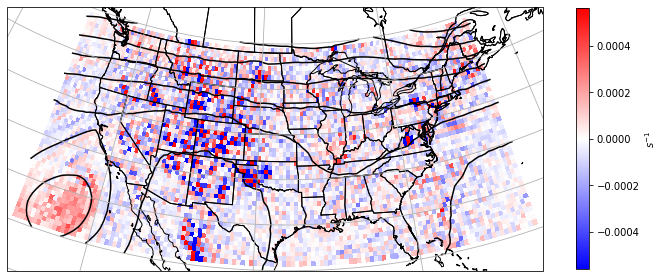

In [27]:
# GFS uses lon/lat grid
data_projection = ccrs.PlateCarree()

# Make it easy to change what time step we look at
#t_step = 0
# select a level
lev = 21 # 500mb

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal())

# Don't plot boudaries now
var = qgpv_v[lev, :, :]
vmax = max(var[1:-1,1:-1].max(), abs(var[1:-1,1:-1].min()))
mesh = ax.pcolormesh(lon[1:-1], lat[1:-1], var[1:-1,1:-1], 
                     transform=data_projection, zorder=0, cmap='bwr', vmin=-vmax/10, vmax=vmax/10)

#ax.contour(lon[1:-1], lat[1:-1], qgpv[lev,1:-1,1:-1]*1.e5,
#           transform=data_projection) #levels=np.arange(20,120,20),t

# plot geopotential height
ax.contour(lon, lat, phi[21,:,:],transform=data_projection, colors='k')

# add some common geographic features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

# add some lat/lon gridlines
ax.gridlines()

# add a colorbar
cax = fig.colorbar(mesh, shrink=0.6)
cax.set_label(r'$s^{-1}$')

## Scale Analysis

Relative vorticity term
$
\frac{1}{f_0} \nabla^2 \phi ^\prime
$
scales as
$
10^4 \frac{1}{(10^5)^2} 10^2 = 10^{-4}
$


While stretching term at 500mb, where S = 6e-08
$
f_0 \frac{\partial}{\partial p} \frac{1}{S} \frac{\partial \phi ^\prime}{\partial p}
$
scales as
$10^{-4} \frac{1}{(10^4)^2} \frac{1}{10^7} 10^4 = 10^{-1}$

In [59]:
10 * (phi[21, 34, 52] - phi[21, 34, 48] )

<xarray.DataArray 'Geopotential_height_isobaric' ()>
array(70.20019531)
Coordinates:
    reftime    datetime64[ns] 2020-05-25T06:00:00
    time       datetime64[ns] 2020-05-25T15:00:00
    isobaric6  float32 50000.0
    lat        float32 33.0